In [42]:
import pickle
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
# import torch
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from Backtester_FO import YFCrossSectionalBT

In [43]:
data = pd.read_pickle("VADERBERT_S&P.pkl")
data

,companyid,CIK,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,companyname,mostimportantdateutc,word_counts,content,positive_indicators,negative_indicators,sentiment,pos_neg_diff
0,100231,0000732717,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-01-26,8416.0,"Good morning, ladies and gentlemen, and welcom...",[business we also show full quarter pro forma...,[second i need to cover our safe harbor state...,"{'neg': 0.0305, 'neu': 0.854, 'pos': 0.1159999...",0.0855
1,100231,0000732717,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-04-25,8143.0,"Good morning, ladies and gentlemen, and welcom...",[you will also find pro forma statements that ...,[before we get started i need to cover our sa...,"{'neg': 0.022000000000000002, 'neu': 0.8715, '...",0.0845
2,100231,0000732717,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-10-23,9886.0,Good morning ladies and gentlemen and welcome...,[in the third quarter margins expanded in bot...,[information set forth in this presentation co...,"{'neg': 0.027499999999999997, 'neu': 0.8505, '...",0.0940
3,972190,0001467373,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",Accenture plc,2006-12-20,5745.0,Ladies and gentleman thank you for standing by...,[as a reminder when we discuss revenues today...,[some of the matters we will discuss on this c...,"{'neg': 0.0625, 'neu': 0.8300000000000001, 'po...",0.0445
4,24321,0000796343,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",Adobe Inc.,2006-03-22,9196.0,Good afternoon. My name is Ian and I’ll be you...,[ before we get started i want to emphasize t...,[ before we get started i want to emphasize t...,"{'neg': 0.0455, 'neu': 0.8895, 'pos': 0.065, '...",0.0195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,315476,0000109380,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah","Zions Bancorporation, National Association",2023-04-19,19593.0,"Greetings, and welcome to Zions Bancorp Q1 Ear...",[and the most valuable part of our deposit bas...,[ also with us today include our guests inc...,"{'neg': 0.0525, 'neu': 0.8225, 'pos': 0.125, '...",0.0725
967,215548781,0001555280,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-02-14,20038.0,Welcome to the Fourth Quarter and Full Year 20...,[ our 8% operational revenue growth for the ye...,[ our 8% operational revenue growth for the ye...,"{'neg': 0.0215, 'neu': 0.8095, 'pos': 0.168999...",0.1475
968,215548781,0001555280,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-05-04,17516.0,Welcome to the First Quarter 2023 Financial Re...,[today we reported solid first quarter result...,[in the first quarter our international segme...,"{'neg': 0.0125, 'neu': 0.851, 'pos': 0.1365, '...",0.1240
969,27862,0001065088,EBAY,eBay,Consumer Discretionary,Internet & Direct Marketing Retail,"San Jose, California",eBay Inc.,2023-02-22,18495.0,"Ladies and gentlemen, thank you for standing b...",[additionally all growth rates noted in our p...,[these forward looking statements involve know...,"{'neg': 0.041, 'neu': 0.8435, 'pos': 0.1155, '...",0.0745


In [44]:
data.reset_index(drop = True, inplace = True)
data.insert(2, "year", pd.to_datetime(data["mostimportantdateutc"]).dt.year)
data = data.replace('BF.B', 'BF-B')

In [45]:
data["sentiment"][0]

{'neg': 0.0305, 'neu': 0.854, 'pos': 0.11599999999999999, 'compound': 0.98105}

In [46]:
data["mostimportantdateutc"] = pd.to_datetime(data["mostimportantdateutc"])

In [47]:
direction = []
sentiment_magnitude = []
for i in data["sentiment"]:
    max_key = ''
    max_value = float('-inf')

    for key, value in i.items():
        if key in ['neg', 'pos']:
            if value > max_value:
                max_value = value
                max_key = key
    if max_key == "pos":
        direction.append(1)
    else:
        direction.append(-1)
    sentiment_magnitude.append(max_value)

In [48]:
data.insert(2, "Direction", direction)
data.insert(3, "sentiment_magnitude", sentiment_magnitude)

In [49]:
data["pos_neg_diff"].describe()

count    29579.000000
mean         0.088177
std          0.040643
min         -0.152000
25%          0.062000
50%          0.088500
75%          0.114500
max          0.350500
Name: pos_neg_diff, dtype: float64

In [50]:
tuned_data = data[data["pos_neg_diff"] >= data["pos_neg_diff"].describe().loc["25%"]]
tuned_data = tuned_data.reset_index(drop = True)
tuned_data

,companyid,CIK,Direction,sentiment_magnitude,year,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,companyname,mostimportantdateutc,word_counts,content,positive_indicators,negative_indicators,sentiment,pos_neg_diff
0,100231,0000732717,1,0.1160,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-01-26,8416.0,"Good morning, ladies and gentlemen, and welcom...",[business we also show full quarter pro forma...,[second i need to cover our safe harbor state...,"{'neg': 0.0305, 'neu': 0.854, 'pos': 0.1159999...",0.0855
1,100231,0000732717,1,0.1065,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-04-25,8143.0,"Good morning, ladies and gentlemen, and welcom...",[you will also find pro forma statements that ...,[before we get started i need to cover our sa...,"{'neg': 0.022000000000000002, 'neu': 0.8715, '...",0.0845
2,100231,0000732717,1,0.1215,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-10-23,9886.0,Good morning ladies and gentlemen and welcome...,[in the third quarter margins expanded in bot...,[information set forth in this presentation co...,"{'neg': 0.027499999999999997, 'neu': 0.8505, '...",0.0940
3,24321,0000796343,1,0.0960,2006,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",Adobe Inc.,2006-12-14,10828.0,"Good day, everyone, and welcome to the Adobe F...",[before we get started i want to emphasize th...,[before we get started i want to emphasize th...,"{'neg': 0.019, 'neu': 0.885, 'pos': 0.096, 'co...",0.0770
4,168864,0000002488,1,0.1305,2006,AMD,AMD,Information Technology,Semiconductors,"Santa Clara, California","Advanced Micro Devices, Inc.",2006-04-12,9033.0,Good afternoon and welcome to the Advanced Mic...,[the first quarter was yet another in a series...,[investors are cautioned that our forward look...,"{'neg': 0.0295, 'neu': 0.8400000000000001, 'po...",0.1010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22201,315476,0000109380,1,0.1250,2023,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah","Zions Bancorporation, National Association",2023-04-19,19593.0,"Greetings, and welcome to Zions Bancorp Q1 Ear...",[and the most valuable part of our deposit bas...,[ also with us today include our guests inc...,"{'neg': 0.0525, 'neu': 0.8225, 'pos': 0.125, '...",0.0725
22202,215548781,0001555280,1,0.1690,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-02-14,20038.0,Welcome to the Fourth Quarter and Full Year 20...,[ our 8% operational revenue growth for the ye...,[ our 8% operational revenue growth for the ye...,"{'neg': 0.0215, 'neu': 0.8095, 'pos': 0.168999...",0.1475
22203,215548781,0001555280,1,0.1365,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-05-04,17516.0,Welcome to the First Quarter 2023 Financial Re...,[today we reported solid first quarter result...,[in the first quarter our international segme...,"{'neg': 0.0125, 'neu': 0.851, 'pos': 0.1365, '...",0.1240
22204,27862,0001065088,1,0.1155,2023,EBAY,eBay,Consumer Discretionary,Internet & Direct Marketing Retail,"San Jose, California",eBay Inc.,2023-02-22,18495.0,"Ladies and gentlemen, thank you for standing b...",[additionally all growth rates noted in our p...,[these forward looking statements involve know...,"{'neg': 0.041, 'neu': 0.8435, 'pos': 0.1155, '...",0.0745


In [51]:
tuned_data2 = data[data["pos_neg_diff"] >= data["pos_neg_diff"].describe().loc["50%"]]
tuned_data2 = tuned_data2.reset_index(drop = True)
tuned_data2

,companyid,CIK,Direction,sentiment_magnitude,year,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,companyname,mostimportantdateutc,word_counts,content,positive_indicators,negative_indicators,sentiment,pos_neg_diff
0,100231,0000732717,1,0.1215,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-10-23,9886.0,Good morning ladies and gentlemen and welcome...,[in the third quarter margins expanded in bot...,[information set forth in this presentation co...,"{'neg': 0.027499999999999997, 'neu': 0.8505, '...",0.0940
1,168864,0000002488,1,0.1305,2006,AMD,AMD,Information Technology,Semiconductors,"Santa Clara, California","Advanced Micro Devices, Inc.",2006-04-12,9033.0,Good afternoon and welcome to the Advanced Mic...,[the first quarter was yet another in a series...,[investors are cautioned that our forward look...,"{'neg': 0.0295, 'neu': 0.8400000000000001, 'po...",0.1010
2,24522,0001086222,1,0.1715,2006,AKAM,Akamai,Information Technology,Internet Services & Infrastructure,"Cambridge, Massachusetts","Akamai Technologies, Inc.",2006-02-08,9471.0,Good afternoon my name is Jean and I will be y...,[ actual results may differ materially from th...,[ actual results may differ materially from th...,"{'neg': 0.077, 'neu': 0.7515000000000001, 'pos...",0.0945
3,24522,0001086222,1,0.1380,2006,AKAM,Akamai,Information Technology,Internet Services & Infrastructure,"Cambridge, Massachusetts","Akamai Technologies, Inc.",2006-10-26,8676.0,Good afternoon. My name is Cruise and I will b...,[results for the third quarter include revenue...,[these statements are based on current expecta...,"{'neg': 0.045, 'neu': 0.817, 'pos': 0.138, 'co...",0.0930
4,29096,0001652044,1,0.1355,2006,GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services,"Mountain View, California",Alphabet Inc.,2006-07-20,9733.0,"Good day, everyone, and welcome to the Google,...",[some of the comments we will make today are f...,[ these statements involve a number of risks a...,"{'neg': 0.043000000000000003, 'neu': 0.821, 'p...",0.0925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14847,264048,0001136869,1,0.1570,2023,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana","Zimmer Biomet Holdings, Inc.",2023-02-03,20391.0,"Good morning, ladies and gentlemen, and welcom...",[ we again saw better than expected growth dri...,[actual results may differ materially from tho...,"{'neg': 0.0615, 'neu': 0.781, 'pos': 0.157, 'c...",0.0955
14848,315476,0000109380,1,0.1860,2023,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah","Zions Bancorporation, National Association",2023-01-23,12795.0,"Greetings, and welcome to the Zions Bancorp Q4...",[first our balance sheet which is supported ...,[with us also today are scott mclean presiden...,"{'neg': 0.05, 'neu': 0.764, 'pos': 0.186, 'com...",0.1360
14849,215548781,0001555280,1,0.1690,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-02-14,20038.0,Welcome to the Fourth Quarter and Full Year 20...,[ our 8% operational revenue growth for the ye...,[ our 8% operational revenue growth for the ye...,"{'neg': 0.0215, 'neu': 0.8095, 'pos': 0.168999...",0.1475
14850,215548781,0001555280,1,0.1365,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-05-04,17516.0,Welcome to the First Quarter 2023 Financial Re...,[today we reported solid first quarter result...,[in the first quarter our international segme...,"{'neg': 0.0125, 'neu': 0.851, 'pos': 0.1365, '...",0.1240


In [52]:
tuned_data3 = data[data["pos_neg_diff"] >= data["pos_neg_diff"].describe().loc["75%"]]
tuned_data3 = tuned_data3.reset_index(drop = True)
tuned_data3

,companyid,CIK,Direction,sentiment_magnitude,year,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,companyname,mostimportantdateutc,word_counts,content,positive_indicators,negative_indicators,sentiment,pos_neg_diff
0,135470,0000004904,1,0.1415,2006,AEP,American Electric Power,Utilities,Electric Utilities,"Columbus, Ohio","American Electric Power Company, Inc.",2006-10-31,17329.0,"Ladies and gentlemen, thank you for standing b...",[rate increases primarily in ohio and kentucky...,[the earnings release and other matters that m...,"{'neg': 0.017, 'neu': 0.8415, 'pos': 0.1415, '...",0.1245
1,126269,0000008670,1,0.1785,2006,ADP,ADP,Industrials,Human Resource & Employment Services,"Roseland, New Jersey","Automatic Data Processing, Inc.",2006-07-27,14129.0,Good morning. My name is Carol and I will be y...,[ revenue growth for the quarter was 14% whic...,[ during today's conference call we will disc...,"{'neg': 0.041499999999999995, 'neu': 0.78, 'po...",0.1370
2,285544,0000701985,1,0.1455,2006,BBWI,"Bath & Body Works, Inc.",Consumer Discretionary,Specialty Stores,"Columbus, Ohio","Bath & Body Works, Inc.",2006-08-17,8638.0,"Welcome to the Limited Brands, Inc. second qua...",[lastly we are investing in a new distributio...,[ victoria’s secret beauty results exceeded e...,"{'neg': 0.0235, 'neu': 0.831, 'pos': 0.1455000...",0.1220
3,255397,0000764478,1,0.1430,2006,BBY,Best Buy,Consumer Discretionary,Computer & Electronics Retail,"Richfield, Minnesota","Best Buy Co., Inc.",2006-03-30,9475.0,Welcome to Best Buy's conference call for the ...,[ as we announced this morning our fourth quar...,[i would like to remind you that comments made...,"{'neg': 0.017, 'neu': 0.8394999999999999, 'pos...",0.1260
4,25941,0000813672,1,0.1720,2006,CDNS,Cadence Design Systems,Information Technology,Application Software,"San Jose, California","Cadence Design Systems, Inc.",2006-10-25,7433.0,"Good afternoon, my name is Michelle, and I wil...",[revenue grew 9% year over year led by sales o...,[but i'm wondering if you're seeing any increa...,"{'neg': 0.03, 'neu': 0.798, 'pos': 0.172, 'com...",0.1420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7390,393488,0000877212,1,0.1720,2023,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",Zebra Technologies Corporation,2023-05-02,16118.0,"Good day, and welcome to the Zebra Technologie...",[throughout this presentation unless otherwis...,[ our forward looking statements are based on ...,"{'neg': 0.0335, 'neu': 0.7945, 'pos': 0.172, '...",0.1385
7391,315476,0000109380,1,0.1860,2023,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah","Zions Bancorporation, National Association",2023-01-23,12795.0,"Greetings, and welcome to the Zions Bancorp Q4...",[first our balance sheet which is supported ...,[with us also today are scott mclean presiden...,"{'neg': 0.05, 'neu': 0.764, 'pos': 0.186, 'com...",0.1360
7392,215548781,0001555280,1,0.1690,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-02-14,20038.0,Welcome to the Fourth Quarter and Full Year 20...,[ our 8% operational revenue growth for the ye...,[ our 8% operational revenue growth for the ye...,"{'neg': 0.0215, 'neu': 0.8095, 'pos': 0.168999...",0.1475
7393,215548781,0001555280,1,0.1365,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-05-04,17516.0,Welcome to the First Quarter 2023 Financial Re...,[today we reported solid first quarter result...,[in the first quarter our international segme...,"{'neg': 0.0125, 'neu': 0.851, 'pos': 0.1365, '...",0.1240


In [53]:
tuned_data4 = data[data["pos_neg_diff"] >= (data["pos_neg_diff"].describe().loc["50%"] - data["pos_neg_diff"].describe().loc["25%"])]
tuned_data4 = tuned_data4.reset_index(drop = True)
tuned_data4

,companyid,CIK,Direction,sentiment_magnitude,year,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,companyname,mostimportantdateutc,word_counts,content,positive_indicators,negative_indicators,sentiment,pos_neg_diff
0,100231,0000732717,1,0.1160,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-01-26,8416.0,"Good morning, ladies and gentlemen, and welcom...",[business we also show full quarter pro forma...,[second i need to cover our safe harbor state...,"{'neg': 0.0305, 'neu': 0.854, 'pos': 0.1159999...",0.0855
1,100231,0000732717,1,0.1065,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-04-25,8143.0,"Good morning, ladies and gentlemen, and welcom...",[you will also find pro forma statements that ...,[before we get started i need to cover our sa...,"{'neg': 0.022000000000000002, 'neu': 0.8715, '...",0.0845
2,100231,0000732717,1,0.1215,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-10-23,9886.0,Good morning ladies and gentlemen and welcome...,[in the third quarter margins expanded in bot...,[information set forth in this presentation co...,"{'neg': 0.027499999999999997, 'neu': 0.8505, '...",0.0940
3,972190,0001467373,1,0.1070,2006,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",Accenture plc,2006-12-20,5745.0,Ladies and gentleman thank you for standing by...,[as a reminder when we discuss revenues today...,[some of the matters we will discuss on this c...,"{'neg': 0.0625, 'neu': 0.8300000000000001, 'po...",0.0445
4,24321,0000796343,1,0.0685,2006,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",Adobe Inc.,2006-06-15,9579.0,Good afternoon. My name is Ian and I will be y...,[ before we get started i want to emphasize t...,[ before we get started i want to emphasize t...,"{'neg': 0.0295, 'neu': 0.9025000000000001, 'po...",0.0390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27782,315476,0000109380,1,0.1250,2023,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah","Zions Bancorporation, National Association",2023-04-19,19593.0,"Greetings, and welcome to Zions Bancorp Q1 Ear...",[and the most valuable part of our deposit bas...,[ also with us today include our guests inc...,"{'neg': 0.0525, 'neu': 0.8225, 'pos': 0.125, '...",0.0725
27783,215548781,0001555280,1,0.1690,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-02-14,20038.0,Welcome to the Fourth Quarter and Full Year 20...,[ our 8% operational revenue growth for the ye...,[ our 8% operational revenue growth for the ye...,"{'neg': 0.0215, 'neu': 0.8095, 'pos': 0.168999...",0.1475
27784,215548781,0001555280,1,0.1365,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-05-04,17516.0,Welcome to the First Quarter 2023 Financial Re...,[today we reported solid first quarter result...,[in the first quarter our international segme...,"{'neg': 0.0125, 'neu': 0.851, 'pos': 0.1365, '...",0.1240
27785,27862,0001065088,1,0.1155,2023,EBAY,eBay,Consumer Discretionary,Internet & Direct Marketing Retail,"San Jose, California",eBay Inc.,2023-02-22,18495.0,"Ladies and gentlemen, thank you for standing b...",[additionally all growth rates noted in our p...,[these forward looking statements involve know...,"{'neg': 0.041, 'neu': 0.8435, 'pos': 0.1155, '...",0.0745


In [54]:
tuned_data5 = data[data["pos_neg_diff"] >= (data["pos_neg_diff"].describe().loc["75%"] - data["pos_neg_diff"].describe().loc["50%"])]
tuned_data5 = tuned_data5.reset_index(drop = True)
tuned_data5

,companyid,CIK,Direction,sentiment_magnitude,year,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,companyname,mostimportantdateutc,word_counts,content,positive_indicators,negative_indicators,sentiment,pos_neg_diff
0,100231,0000732717,1,0.1160,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-01-26,8416.0,"Good morning, ladies and gentlemen, and welcom...",[business we also show full quarter pro forma...,[second i need to cover our safe harbor state...,"{'neg': 0.0305, 'neu': 0.854, 'pos': 0.1159999...",0.0855
1,100231,0000732717,1,0.1065,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-04-25,8143.0,"Good morning, ladies and gentlemen, and welcom...",[you will also find pro forma statements that ...,[before we get started i need to cover our sa...,"{'neg': 0.022000000000000002, 'neu': 0.8715, '...",0.0845
2,100231,0000732717,1,0.1215,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-10-23,9886.0,Good morning ladies and gentlemen and welcome...,[in the third quarter margins expanded in bot...,[information set forth in this presentation co...,"{'neg': 0.027499999999999997, 'neu': 0.8505, '...",0.0940
3,972190,0001467373,1,0.1070,2006,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",Accenture plc,2006-12-20,5745.0,Ladies and gentleman thank you for standing by...,[as a reminder when we discuss revenues today...,[some of the matters we will discuss on this c...,"{'neg': 0.0625, 'neu': 0.8300000000000001, 'po...",0.0445
4,24321,0000796343,1,0.0685,2006,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",Adobe Inc.,2006-06-15,9579.0,Good afternoon. My name is Ian and I will be y...,[ before we get started i want to emphasize t...,[ before we get started i want to emphasize t...,"{'neg': 0.0295, 'neu': 0.9025000000000001, 'po...",0.0390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27785,315476,0000109380,1,0.1250,2023,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah","Zions Bancorporation, National Association",2023-04-19,19593.0,"Greetings, and welcome to Zions Bancorp Q1 Ear...",[and the most valuable part of our deposit bas...,[ also with us today include our guests inc...,"{'neg': 0.0525, 'neu': 0.8225, 'pos': 0.125, '...",0.0725
27786,215548781,0001555280,1,0.1690,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-02-14,20038.0,Welcome to the Fourth Quarter and Full Year 20...,[ our 8% operational revenue growth for the ye...,[ our 8% operational revenue growth for the ye...,"{'neg': 0.0215, 'neu': 0.8095, 'pos': 0.168999...",0.1475
27787,215548781,0001555280,1,0.1365,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-05-04,17516.0,Welcome to the First Quarter 2023 Financial Re...,[today we reported solid first quarter result...,[in the first quarter our international segme...,"{'neg': 0.0125, 'neu': 0.851, 'pos': 0.1365, '...",0.1240
27788,27862,0001065088,1,0.1155,2023,EBAY,eBay,Consumer Discretionary,Internet & Direct Marketing Retail,"San Jose, California",eBay Inc.,2023-02-22,18495.0,"Ladies and gentlemen, thank you for standing b...",[additionally all growth rates noted in our p...,[these forward looking statements involve know...,"{'neg': 0.041, 'neu': 0.8435, 'pos': 0.1155, '...",0.0745


In [55]:
def import_stock_data(ticker, start_date = "2006-01-17", end_date = "2023-05-25"):
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    data_dict[ticker] = pd.DataFrame(stock_data)

def stock_returns(data, year, calendar_days):
    initial_data = data[data["year"] == year]
    groupby_data = initial_data.groupby(["mostimportantdateutc", "Symbol"]).sum()
    each_returns = []
    for iterations in range(len(groupby_data.index)):
        stock_returns = []
        # Example usage 
        ticker =  groupby_data.index[iterations][1]
        start_date = groupby_data.index[iterations][0]
        # days = calendar_days
        stock_data = data_dict[ticker]
        # Import stock data
        # stock_data = import_stock_data(ticker, start_date, end_date) 
        for i in range(1, calendar_days):
            end_date = start_date + timedelta(days = i)
            if end_date in stock_data.index:
                terminal_return = ((stock_data["Close"].loc[end_date]/stock_data["Open"].iloc[1]) - 1)
                position_return = terminal_return * groupby_data["Direction"][iterations]
                stock_returns.append(position_return)
            else:
                pass
        each_returns.append(stock_returns)
    return pd.DataFrame(each_returns, index = groupby_data.index)

In [56]:
# data_dict = {}
# for i in data["Symbol"].unique():
#     import_stock_data(i)

In [57]:
test_data = pd.read_csv("data_dict.csv")
test_data["Date"] = pd.to_datetime(test_data["Date"])
test_data = test_data.set_index("Unnamed: 0")
test_data.index.names = ["Symbol"]
groupby_data = test_data.groupby(["Symbol", "Date"]).sum()
data_dict = {}
for i in groupby_data.index.get_level_values(0).unique():
    data_dict.update({i: groupby_data.loc[(i, slice(None))]})

In [58]:
tester = stock_returns(data, 2006, 91)
tester

0         1         2         3         4   \
mostimportantdateutc Symbol                                                     
2006-01-17           IBM    -0.002381 -0.010833 -0.031429 -0.030833 -0.037500   
                     INTC   -0.011806 -0.020551 -0.048535 -0.066463 -0.069523   
2006-01-18           AAPL   -0.048628 -0.084136 -0.065118 -0.084738 -0.106885   
                     LRCX    0.171207  0.122329  0.134081  0.180823  0.170406   
2006-01-19           MCHP    0.033688  0.040189  0.059102  0.066194  0.103428   
...                               ...       ...       ...       ...       ...   
2006-12-20           ACN     0.205457  0.198225  0.193294  0.201512  0.225181   
                     DRI     0.020424  0.031912  0.036763  0.033954  0.038039   
                     KMX     0.859619  0.853380  0.876257  0.887002  0.874870   
                     NKE     0.179189  0.175073  0.176955  0.170135  0.166373   
2006-12-22           WBA     0.059616  0.053906  0.052307  0.048196  0.052307   

                                   5         6         7         8         9   \
mostimportantdateutc Symbol                                                     
2006-01-17           IBM    -0.036786 -0.039048 -0.035476 -0.028214 -0.032143   
                     INTC   -0.072584 -0.060341 -0.052471 -0.053345 -0.070398   
2006-01-18           AAPL   -0.129393 -0.133004 -0.097256 -0.091117 -0.092200   
                     LRCX    0.213942  0.237180  0.251603  0.240118  0.252404   
2006-01-19           MCHP    0.090426  0.108451  0.108451  0.115248  0.093381   
...                               ...       ...       ...       ...       ...   
2006-12-20           ACN     0.214004  0.195924  0.222880  0.205786  0.223208   
                     DRI     0.025530  0.029359  0.019913 -0.001021 -0.011488   
                     KMX     0.858925  0.916464  0.920277  0.947660  0.920277   
                     NKE     0.164374  0.148383  0.160141  0.162022  0.158495   
2006-12-22           WBA     0.054363  0.039287  0.043627  0.049109  0.041115   

                             ...        53        54        55        56  \
mostimportantdateutc Symbol  ...                                           
2006-01-17           IBM     ... -0.006548  0.002024 -0.002262 -0.018095   
                     INTC    ... -0.156100 -0.148229 -0.152602 -0.158723   
2006-01-18           AAPL    ... -0.191021 -0.142513 -0.159966 -0.173447   
                     LRCX    ...  0.174680  0.217147  0.209402  0.192308   
2006-01-19           MCHP    ...  0.095449  0.079196  0.082447  0.066785   
...                          ...       ...       ...       ...       ...   
2006-12-20           ACN     ...  0.172913  0.165680  0.150559  0.159106   
                     DRI     ...  0.001532  0.011233  0.011233  0.006638   
                     KMX     ...  0.761525  0.707106  0.746274  0.767764   
                     NKE     ...  0.229865  0.232451  0.242328  0.263610   
2006-12-22           WBA     ...  0.044313  0.056647  0.062814  0.059159   

                                   57        58        59        60        61  \
mostimportantdateutc Symbol                                                     
2006-01-17           IBM    -0.022619 -0.033810 -0.038690 -0.024048 -0.028095   
                     INTC   -0.153476 -0.162221 -0.163970 -0.149541 -0.160909   
2006-01-18           AAPL   -0.181632 -0.197039 -0.199928 -0.219909 -0.202937   
                     LRCX    0.196314  0.194177  0.249199  0.205395  0.248665   
2006-01-19           MCHP    0.070331  0.062648  0.044031  0.070035  0.096336   
...                               ...       ...       ...       ...       ...   
2006-12-20           ACN     0.176529  0.193294       NaN       NaN       NaN   
                     DRI     0.038295  0.055144       NaN       NaN       NaN   
                     KMX     0.874177  0.868284       NaN       NaN       NaN   
                     NKE     0.273604  0.284538

In [59]:
def signal2portfolio(signaldf):
    temp = signaldf.loc[:,[0]]
    temp.loc[:,[0]] = 1
    temp = temp.groupby('mostimportantdateutc', group_keys=False).apply(lambda x: x/x.sum())
    temp = temp.unstack().fillna(0)
    temp.columns = temp.columns.get_level_values(1)
    return temp

In [60]:
signal = signal2portfolio(tester)
signal

Symbol,A,AAPL,ACN,ADBE,ADI,ADP,ADSK,AEP,AKAM,AMAT,...,VRSN,VRTX,VZ,WBA,WDC,WMB,WMT,XEL,XOM,YUM
mostimportantdateutc,,,,,,,,,,,,,,,,,,,,,
2006-01-17,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-01-18,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-01-19,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-01-24,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-01-25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-12,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-14,0.0,0.0,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-18,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
adj_open_list = []
for symbol, df in data_dict.items():
    adj_open = (df['Adj Close']/df['Close'])*df['Open']
    adj_open.name = symbol
    adj_open_list.append(adj_open)

adj_open_df = pd.concat(adj_open_list, axis=1)

backtester = YFCrossSectionalBT(adj_open_df.dropna(thresh= 1))

In [63]:
from collections import Counter

def overall_train_test(data, train_year = 13):
    optimal_holding_dict = {}
    for i in range(2006, 2006+train_year):
        daily_returns = stock_returns(data, i, 91).sum()
        optimal_holding = daily_returns[daily_returns == daily_returns.max()].index[0]
        optimal_holding_dict.update({i : optimal_holding})

    values = list(optimal_holding_dict.values())
    counter = Counter(values)
    most_common = counter.most_common()

    # Find the lowest value among the most frequent values
    most_frequent_values = [value for value, count in most_common if count == most_common[0][1]]
    holding_period = min(most_frequent_values)    
    report_dict = {}
    for train in range(2019,2024):
        result = signal2portfolio(stock_returns(data, train, 91))
        report_dict[train] = result
    combined_df = pd.concat(report_dict.values())
    return backtester.backtest(combined_df, delay=1, holding_period= holding_period)

def rolling_method(data):
    report_dict = {}
    for i in range(2006, 2023):
        daily_returns = stock_returns(data, i, 91)
        total_returns = daily_returns.sum()[1:]
        optimal_holding = total_returns[total_returns == total_returns.max()].index[0] # this should return optimal holding for 2006
        result = backtester.backtest(signal2portfolio(daily_returns), delay=1, holding_period=optimal_holding)
        report_dict[i + 1] = result.quick_report()
    combined_df = pd.concat(report_dict.values(), keys = report_dict.keys())
    return combined_df.unstack().reorder_levels([1, 0], axis=1).stack()

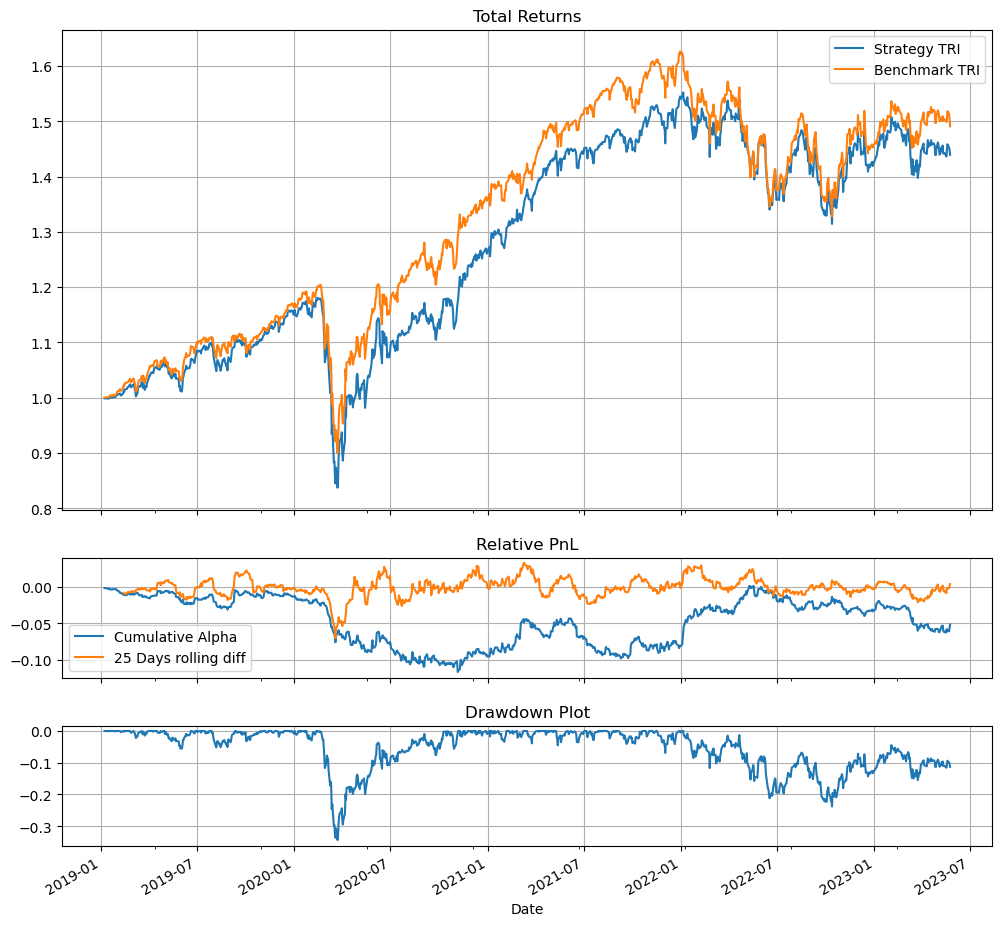

,Strategy,Benchmark
Expected Period Return,0.000380,0.000406
Ann. Sharpe,0.612578,0.687230
Ann. Sortino,0.846716,0.952779
Max DD.,-0.343558,-0.304819
CAGR,0.086771,0.095553
Avg. Daily Turnover,0.023210,NaN


In [ ]:
ori_data = overall_train_test(data)
ori_data.report()

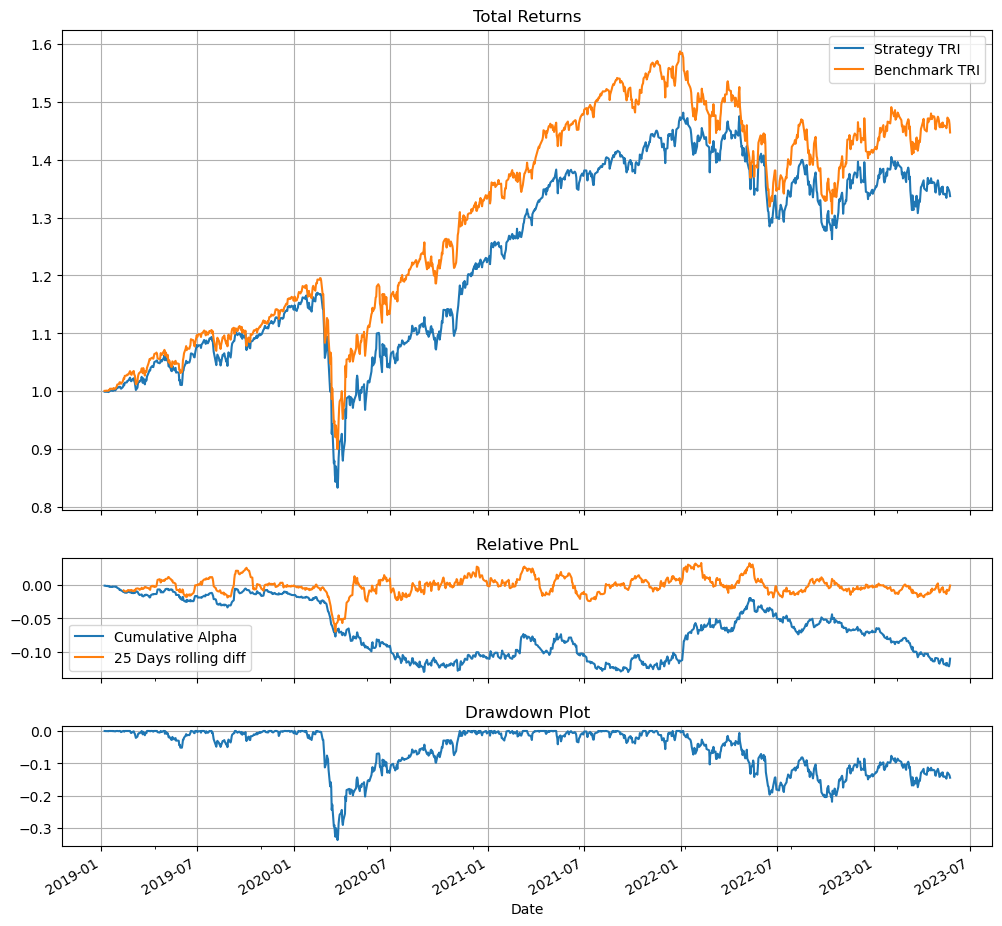

,Strategy,Benchmark
Expected Period Return,0.000307,0.000376
Ann. Sharpe,0.530559,0.665263
Ann. Sortino,0.722096,0.916624
Max DD.,-0.337322,-0.296015
CAGR,0.068630,0.088136
Avg. Daily Turnover,0.022297,NaN


In [ ]:
tuned_method = overall_train_test(tuned_data)
tuned_method.report()

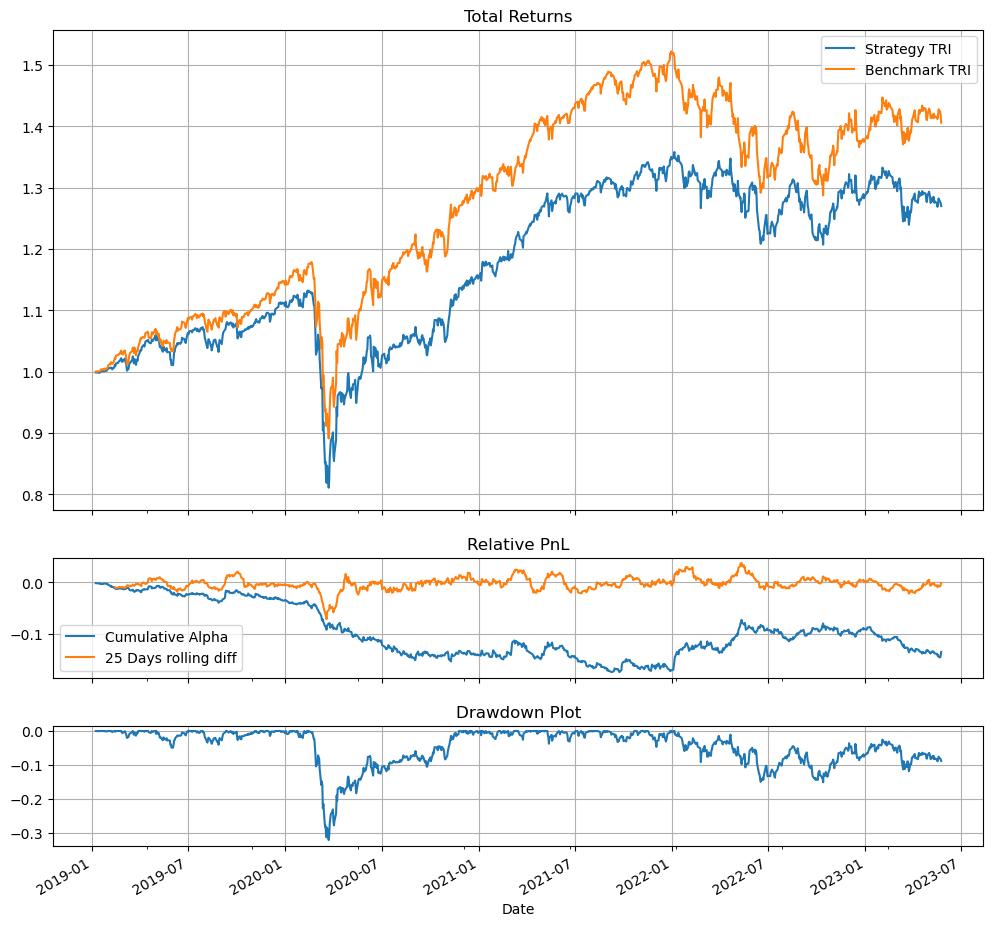

,Strategy,Benchmark
Expected Period Return,0.000254,0.000344
Ann. Sharpe,0.476903,0.654331
Ann. Sortino,0.643287,0.896140
Max DD.,-0.321288,-0.287621
CAGR,0.056140,0.080963
Avg. Daily Turnover,0.020436,NaN


In [ ]:
tuned_method2 = overall_train_test(tuned_data2)
tuned_method2.report()

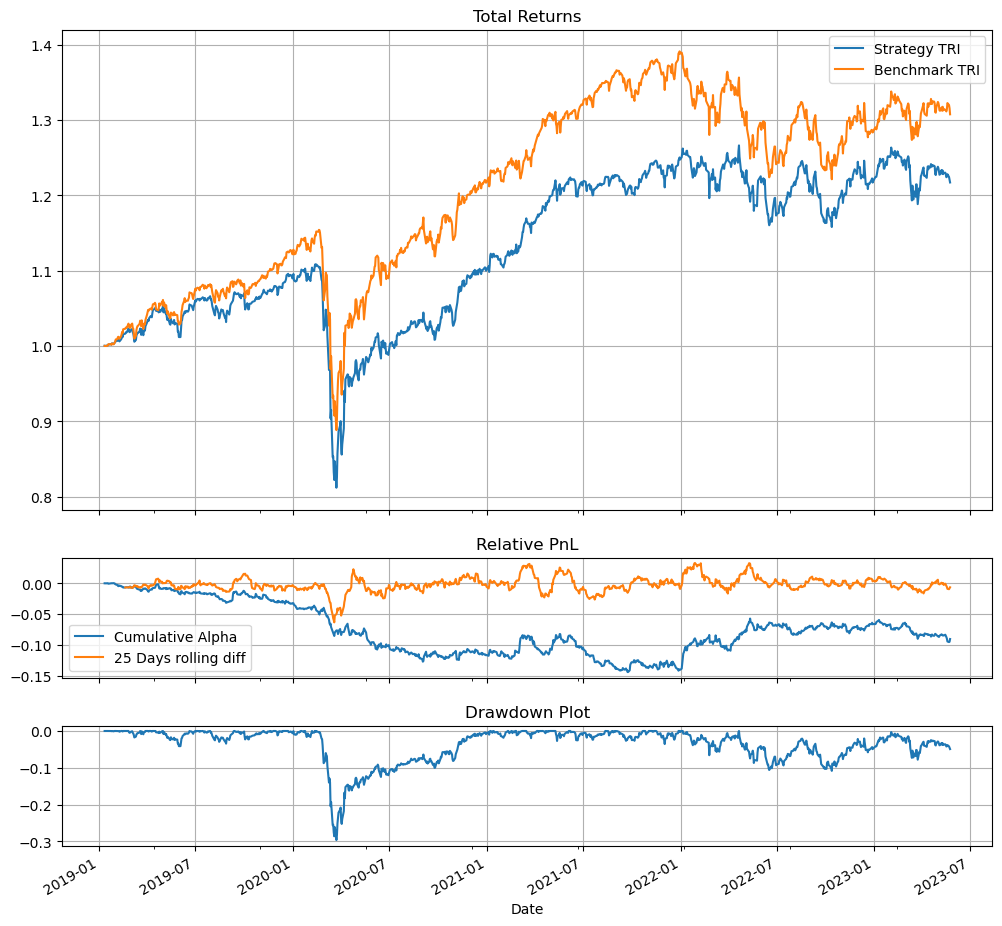

,Strategy,Benchmark
Expected Period Return,0.000204,0.000270
Ann. Sharpe,0.451221,0.595025
Ann. Sortino,0.599940,0.802188
Max DD.,-0.296373,-0.265736
CAGR,0.046026,0.063344
Avg. Daily Turnover,0.017187,NaN


In [ ]:
tuned_method3 = overall_train_test(tuned_data3)
tuned_method3.report()

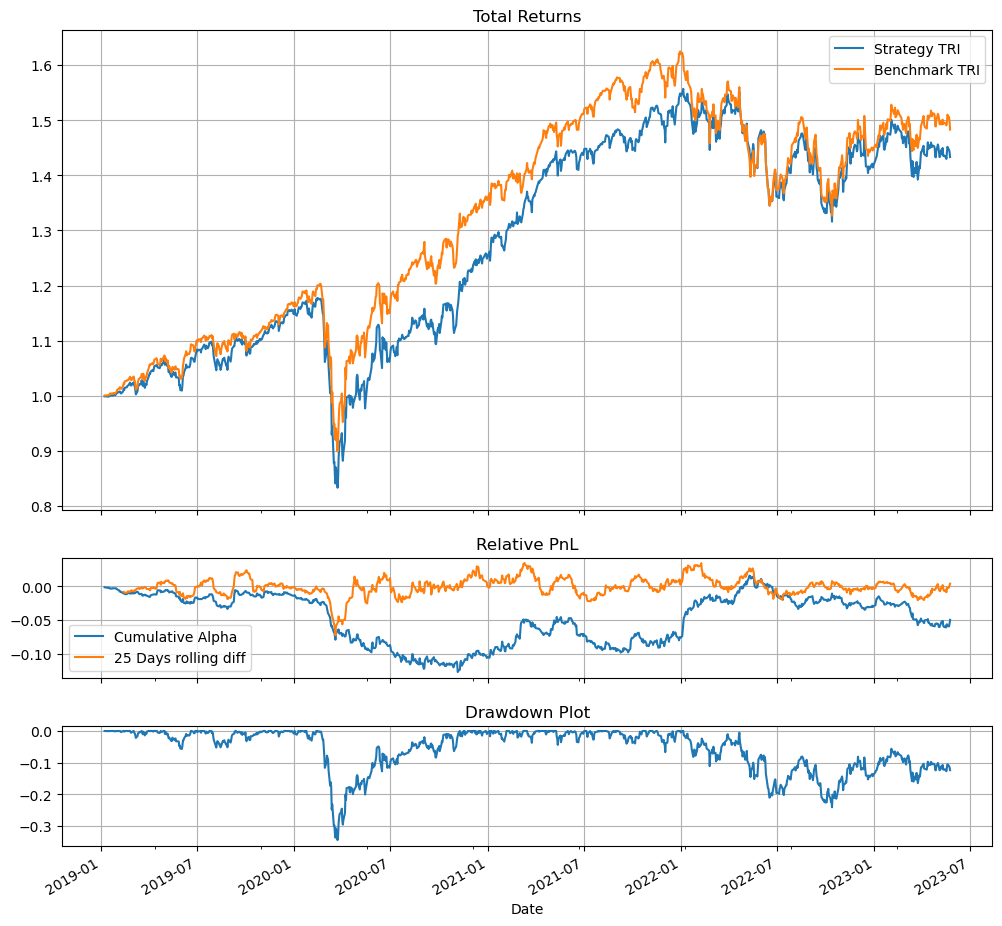

,Strategy,Benchmark
Expected Period Return,0.000375,0.000401
Ann. Sharpe,0.611905,0.682459
Ann. Sortino,0.843017,0.944904
Max DD.,-0.344503,-0.304525
CAGR,0.085702,0.094191
Avg. Daily Turnover,0.023106,NaN


In [ ]:
tuned_method4 = overall_train_test(tuned_data4)
tuned_method4.report()

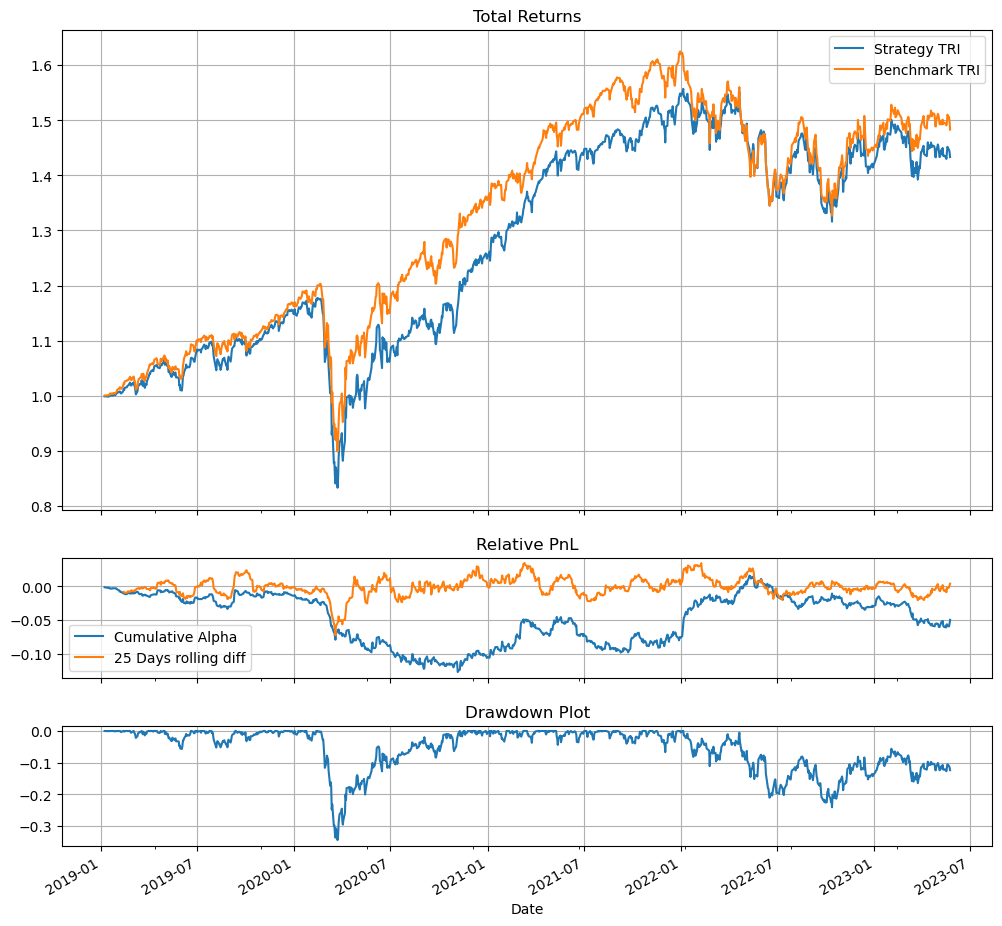

,Strategy,Benchmark
Expected Period Return,0.000375,0.000401
Ann. Sharpe,0.611905,0.682459
Ann. Sortino,0.843017,0.944904
Max DD.,-0.344503,-0.304525
CAGR,0.085702,0.094191
Avg. Daily Turnover,0.023106,NaN


In [ ]:
tuned_method5 = overall_train_test(tuned_data5)
tuned_method5.report()

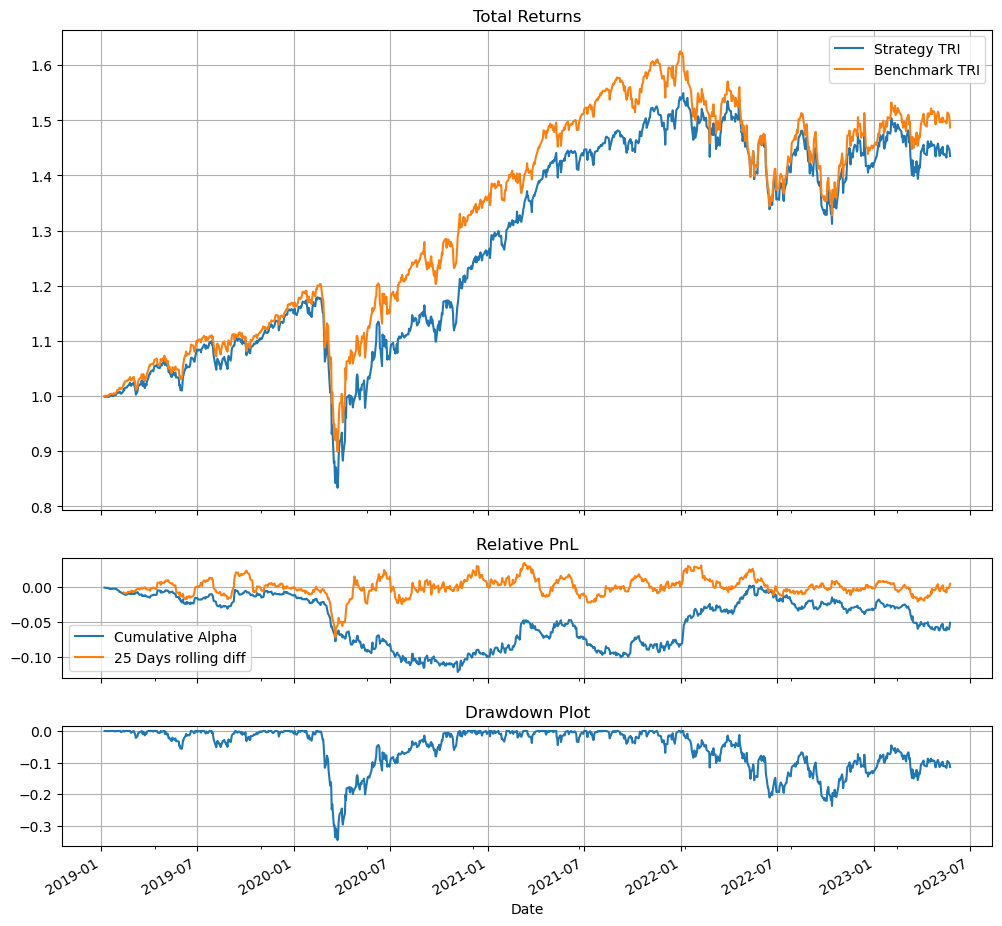

,Strategy,Benchmark
Expected Period Return,0.000377,0.000404
Ann. Sharpe,0.610506,0.684121
Ann. Sortino,0.842044,0.947787
Max DD.,-0.345385,-0.304525
CAGR,0.086073,0.094855
Avg. Daily Turnover,0.023198,NaN


In [65]:
long_data = data[data["Direction"] == 1]
long_data = long_data.reset_index(drop = True)
long_method = overall_train_test(long_data)
long_method.report()

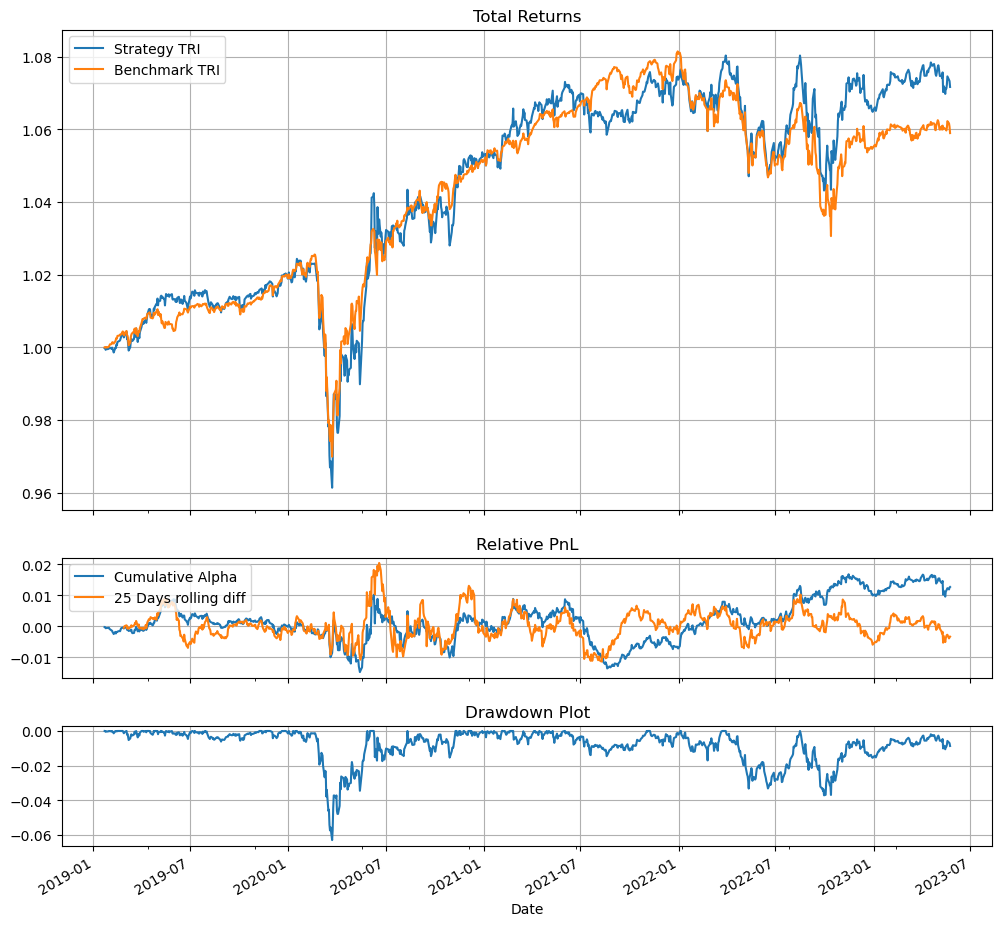

,Strategy,Benchmark
Expected Period Return,0.000066,0.000054
Ann. Sharpe,0.465541,0.489800
Ann. Sortino,0.669390,0.670965
Max DD.,-0.063028,-0.055674
CAGR,0.016079,0.013292
Avg. Daily Turnover,0.003531,NaN


In [66]:
short_data = data[data["Direction"] == -1]
short_data = short_data.reset_index(drop = True)
short_method = overall_train_test(short_data)
short_method.report()

In [67]:
ori_method2 = rolling_method(data)
long_method2 = rolling_method(long_data)
short_method2 = rolling_method(short_data)
tuned1_method2 = rolling_method(tuned_data)
tuned2_method2 = rolling_method(tuned_data2)
tuned3_method2 = rolling_method(tuned_data3)
tuned4_method2 = rolling_method(tuned_data4)
tuned5_method2 = rolling_method(tuned_data5)


In [68]:
ori_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.529458      2.281449                  NaN  0.073735   
     Strategy      1.066782      1.573124             0.013865  0.056991   
2008 Benchmark     0.098974      0.142853                  NaN  0.004907   
     Strategy     -0.143011     -0.199061             0.032669 -0.019290   
2009 Benchmark    -0.693671     -0.958144                  NaN -0.251802   
     Strategy      0.260595      0.384974             0.207688  0.028228   
2010 Benchmark     1.838113      2.895579                  NaN  0.300596   
     Strategy      2.117062      3.431700             0.018968  0.380135   
2011 Benchmark     1.444491      2.107929                  NaN  0.186603   
     Strategy      1.244768      1.799827             0.020472  0.154011   
2012 Benchmark     0.484849      0.670703                  NaN  0.065128   
     Strategy      0.516909      0.723768             0.020146  0.068413   
2013 Benchmark     1.237419      1.919934                  NaN  0.124779   
     Strategy      1.351542      2.096162             0.026164  0.138579   
2014 Benchmark     2.452095      3.635919                  NaN  0.202670   
     Strategy      2.489351      3.684649             0.021530  0.200697   
2015 Benchmark     1.926845      3.078989                  NaN  0.182968   
     Strategy      1.960309      3.146642             0.060227  0.165093   
2016 Benchmark     0.200953      0.259251                  NaN  0.020109   
     Strategy      0.958511      1.302349             0.161290  0.129194   
2017 Benchmark     2.040237      3.167466                  NaN  0.155721   
     Strategy      2.315453      3.663400             0.020770  0.187846   
2018 Benchmark     2.712167      3.916594                  NaN  0.137007   
     Strategy      2.593364      3.789534             0.020339  0.134502   
2019 Benchmark    -0.034847     -0.046549                  NaN -0.011831   
     Strategy      0.201590      0.276903             0.051766  0.017723   
2020 Benchmark     2.045940      3.029323                  NaN  0.169840   
     Strategy      1.835319      2.683932             0.022604  0.155090   
2021 Benchmark     0.907561      1.258067                  NaN  0.176966   
     Strategy      0.729113      1.027208             0.020753  0.145674   
2022 Benchmark     1.125071      1.619661                  NaN  0.095949   
     Strategy      1.452188      2.101899             0.019879  0.128707   
2023 Benchmark    -0.034168     -0.047692                  NaN -0.025994   
     Strategy      0.666040      0.967081             0.158085  0.117148   

                Expected Period Return   Max DD.  
2007 Benchmark                0.000287 -0.046331  
     Strategy                 0.000226 -0.056768  
2008 Benchmark                0.000043 -0.093597  
     Strategy                -0.000056 -0.088198  
2009 Benchmark               -0.000924 -0.400996  
     Strategy                 0.000371 -0.324226  
2010 Benchmark                0.001093 -0.106646  
     Strategy                 0.001333 -0.121244  
2011 Benchmark                0.000712 -0.116857  
     Strategy                 0.000599 -0.125859  
2012 Benchmark                0.000299 -0.170253  
     Strategy                 0.000307 -0.155696  
2013 Benchmark                0.000488 -0.080322  
     Strategy                 0.000537 -0.074446  
2014 Benchmark                0.000747 -0.050521  
     Strategy                 0.000739 -0.045296  
2015 Benchmark                0.000684 -0.069029  
     Strategy                 0.000626 -0.049902  
2016 Benchmark                0.000097 -0.106960  
     Strategy                 0.000505 -0.118352  
2017 Benchmark                0.000588 -0.042519  
     Strategy                 0.000698 -0.037359  
2018 Benchmark                0.000516 -0.032555  
     Strategy                 0.000507 -0.039023  
2019 Benchmark               -0.000017 -0.117912  
     Strategy                

In [69]:
long_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.533883      2.290025                  NaN  0.073447   
     Strategy      1.096857      1.619546             0.013738  0.058612   
2008 Benchmark     0.144347      0.208255                  NaN  0.009410   
     Strategy     -0.046695     -0.065777             0.025214 -0.009963   
2009 Benchmark    -0.688692     -0.951611                  NaN -0.250244   
     Strategy      0.333118      0.493164             0.205393  0.055237   
2010 Benchmark     1.838113      2.895579                  NaN  0.300596   
     Strategy      2.110532      3.417198             0.018970  0.378741   
2011 Benchmark     1.444491      2.107929                  NaN  0.186603   
     Strategy      1.233472      1.785256             0.020467  0.152330   
2012 Benchmark     0.484849      0.670703                  NaN  0.065128   
     Strategy      0.501324      0.701299             0.020205  0.066283   
2013 Benchmark     1.230475      1.907335                  NaN  0.122994   
     Strategy      1.349384      2.087320             0.025944  0.137874   
2014 Benchmark     2.451481      3.633813                  NaN  0.201686   
     Strategy      2.478357      3.663403             0.021413  0.198698   
2015 Benchmark     1.956049      3.143910                  NaN  0.181985   
     Strategy      1.978069      3.190106             0.059550  0.163011   
2016 Benchmark     0.276678      0.361772                  NaN  0.028480   
     Strategy      1.007040      1.382156             0.159498  0.130513   
2017 Benchmark     2.040237      3.167466                  NaN  0.155721   
     Strategy      2.317085      3.662673             0.020776  0.187635   
2018 Benchmark     2.712167      3.916594                  NaN  0.137007   
     Strategy      2.589565      3.784516             0.020348  0.134129   
2019 Benchmark    -0.034847     -0.046549                  NaN -0.011831   
     Strategy      0.198460      0.272565             0.051766  0.017313   
2020 Benchmark     2.044039      3.027943                  NaN  0.168837   
     Strategy      1.814405      2.652968             0.022473  0.152423   
2021 Benchmark     0.907561      1.258067                  NaN  0.176966   
     Strategy      0.726977      1.021164             0.020791  0.144550   
2022 Benchmark     1.125071      1.619661                  NaN  0.095949   
     Strategy      1.478659      2.142521             0.019879  0.130885   
2023 Benchmark    -0.058013     -0.080435                  NaN -0.029906   
     Strategy      0.610709      0.881089             0.157182  0.104535   

                Expected Period Return   Max DD.  
2007 Benchmark                0.000286 -0.045844  
     Strategy                 0.000233 -0.055771  
2008 Benchmark                0.000061 -0.109625  
     Strategy                -0.000018 -0.104310  
2009 Benchmark               -0.000916 -0.399643  
     Strategy                 0.000472 -0.329053  
2010 Benchmark                0.001093 -0.106646  
     Strategy                 0.001329 -0.120843  
2011 Benchmark                0.000712 -0.116857  
     Strategy                 0.000593 -0.126094  
2012 Benchmark                0.000299 -0.170253  
     Strategy                 0.000300 -0.158501  
2013 Benchmark                0.000481 -0.080322  
     Strategy                 0.000534 -0.074466  
2014 Benchmark                0.000744 -0.050521  
     Strategy                 0.000732 -0.046049  
2015 Benchmark                0.000680 -0.065888  
     Strategy                 0.000618 -0.049943  
2016 Benchmark                0.000126 -0.095740  
     Strategy                 0.000506 -0.107405  
2017 Benchmark                0.000588 -0.042519  
     Strategy                 0.000697 -0.037104  
2018 Benchmark                0.000516 -0.032555  
     Strategy                 0.000506 -0.039009  
2019 Benchmark               -0.000017 -0.117912  
     Strategy                

In [70]:
short_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     0.705453      1.100299                  NaN  0.004221   
     Strategy     -0.857885     -1.192981             0.001128 -0.012226   
2008 Benchmark     0.092844      0.134419                  NaN  0.001611   
     Strategy     -0.417571     -0.521791             0.001475 -0.010414   
2009 Benchmark    -0.709715     -0.980317                  NaN -0.040939   
     Strategy     -0.313399     -0.457969             0.003385 -0.023643   
2010 Benchmark     0.302869      0.398593                  NaN  0.010709   
     Strategy      0.399139      0.540132             0.016807  0.020037   
2011 Benchmark     1.233686      1.768314                  NaN  0.025736   
     Strategy      1.087838      1.524539             0.003238  0.028467   
2012 Benchmark     0.581386      0.807359                  NaN  0.011740   
     Strategy      0.758924      1.072595             0.002906  0.017037   
2013 Benchmark     1.829483      2.998241                  NaN  0.027112   
     Strategy      2.070298      3.414237             0.003273  0.037617   
2014 Benchmark     2.757146      4.196095                  NaN  0.029867   
     Strategy      3.069851      5.095288             0.002763  0.042350   
2015 Benchmark     1.371601      1.918021                  NaN  0.020955   
     Strategy      0.875764      1.289221             0.003509  0.016207   
2016 Benchmark    -0.008721     -0.011362                  NaN -0.000400   
     Strategy      0.538916      0.759533             0.002471  0.009678   
2017 Benchmark     2.067664      3.243460                  NaN  0.028453   
     Strategy      1.886054      2.986756             0.003442  0.037099   
2018 Benchmark     3.206486      4.856125                  NaN  0.026962   
     Strategy      2.983624      4.837250             0.003480  0.037849   
2019 Benchmark    -0.125666     -0.169494                  NaN -0.002152   
     Strategy      0.098555      0.133762             0.002344  0.001720   
2020 Benchmark     2.025469      2.840122                  NaN  0.021296   
     Strategy      1.322357      1.869478             0.002688  0.019666   
2021 Benchmark     0.875743      1.218871                  NaN  0.035166   
     Strategy      0.721077      1.107001             0.003570  0.038432   
2022 Benchmark     0.812381      1.115781                  NaN  0.012543   
     Strategy      0.601273      0.822104             0.003530  0.012983   
2023 Benchmark    -0.187104     -0.261208                  NaN -0.007435   
     Strategy      0.157451      0.220808             0.003768  0.004456   

                Expected Period Return   Max DD.  
2007 Benchmark            1.527551e-05 -0.002996  
     Strategy            -5.124970e-05 -0.014604  
2008 Benchmark            6.991031e-06 -0.015671  
     Strategy            -3.657677e-05 -0.018648  
2009 Benchmark           -1.622297e-04 -0.083961  
     Strategy            -8.776660e-05 -0.098608  
2010 Benchmark            5.596698e-05 -0.063086  
     Strategy             1.091434e-04 -0.095229  
2011 Benchmark            1.033053e-04 -0.020483  
     Strategy             1.139250e-04 -0.021639  
2012 Benchmark            4.649152e-05 -0.020073  
     Strategy             6.898483e-05 -0.015926  
2013 Benchmark            1.070053e-04 -0.007262  
     Strategy             1.469295e-04 -0.009225  
2014 Benchmark            1.173587e-04 -0.006027  
     Strategy             1.649472e-04 -0.007029  
2015 Benchmark            8.378487e-05 -0.008878  
     Strategy             6.704529e-05 -0.011363  
2016 Benchmark           -6.129180e-07 -0.014095  
     Strategy             3.735399e-05 -0.010723  
2017 Benchmark            1.125976e-04 -0.006213  
     Strategy             1.446486e-04 -0.011797  
2018 Benchmark            1.062903e-04 -0.003729  
     Strategy             1.505598e-04 -0.005882  
2019 Benchmark           -7.774951e-06 -0.019793  
     Strategy             8.3

In [71]:
tuned1_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.624107      2.422713                  NaN  0.061267   
     Strategy      1.328944      1.986308             0.011072  0.054862   
2008 Benchmark     0.148069      0.213850                  NaN  0.009452   
     Strategy      0.120360      0.171236             0.023235  0.005679   
2009 Benchmark    -0.606563     -0.839437                  NaN -0.220100   
     Strategy      0.540719      0.828731             0.192972  0.130948   
2010 Benchmark     1.760615      2.764798                  NaN  0.257799   
     Strategy      1.878779      3.002213             0.016981  0.279275   
2011 Benchmark     1.410760      2.055045                  NaN  0.175186   
     Strategy      1.335785      1.939857             0.019712  0.156432   
2012 Benchmark     0.481434      0.666181                  NaN  0.060687   
     Strategy      0.419948      0.585408             0.018858  0.049938   
2013 Benchmark     1.255823      1.953340                  NaN  0.110263   
     Strategy      1.442374      2.275070             0.020035  0.125545   
2014 Benchmark     2.480667      3.696223                  NaN  0.187076   
     Strategy      2.562296      3.859463             0.019841  0.181969   
2015 Benchmark     1.922529      3.037247                  NaN  0.161537   
     Strategy      1.763750      2.759224             0.037590  0.132684   
2016 Benchmark     0.384499      0.505997                  NaN  0.040143   
     Strategy      1.129485      1.584070             0.171559  0.146587   
2017 Benchmark     2.070301      3.219155                  NaN  0.150212   
     Strategy      2.508160      4.032883             0.019704  0.189901   
2018 Benchmark     2.707639      3.905523                  NaN  0.132131   
     Strategy      2.532253      3.703658             0.019635  0.126073   
2019 Benchmark    -0.036882     -0.049196                  NaN -0.011011   
     Strategy      0.115641      0.156752             0.048665  0.007173   
2020 Benchmark     2.031890      3.003630                  NaN  0.162344   
     Strategy      1.854124      2.719223             0.021710  0.146636   
2021 Benchmark     0.884662      1.218221                  NaN  0.165408   
     Strategy      0.651160      0.901592             0.020191  0.120357   
2022 Benchmark     1.213355      1.755548                  NaN  0.102665   
     Strategy      1.497840      2.158310             0.027028  0.125747   
2023 Benchmark    -0.115659     -0.159434                  NaN -0.035489   
     Strategy      0.551274      0.781824             0.068087  0.077472   

                Expected Period Return   Max DD.  
2007 Benchmark                0.000238 -0.036599  
     Strategy                 0.000216 -0.035174  
2008 Benchmark                0.000058 -0.100237  
     Strategy                 0.000042 -0.089504  
2009 Benchmark               -0.000776 -0.373809  
     Strategy                 0.000715 -0.284997  
2010 Benchmark                0.000952 -0.105217  
     Strategy                 0.001018 -0.121102  
2011 Benchmark                0.000671 -0.112885  
     Strategy                 0.000604 -0.120187  
2012 Benchmark                0.000276 -0.159383  
     Strategy                 0.000231 -0.151485  
2013 Benchmark                0.000431 -0.073159  
     Strategy                 0.000485 -0.063077  
2014 Benchmark                0.000692 -0.044129  
     Strategy                 0.000676 -0.038594  
2015 Benchmark                0.000608 -0.051924  
     Strategy                 0.000510 -0.043813  
2016 Benchmark                0.000167 -0.091524  
     Strategy                 0.000560 -0.108238  
2017 Benchmark                0.000568 -0.040373  
     Strategy                 0.000703 -0.033492  
2018 Benchmark                0.000498 -0.031533  
     Strategy                 0.000477 -0.037096  
2019 Benchmark               -0.000017 -0.105266  
     Strategy                

In [72]:
tuned2_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.538524      2.267219                  NaN  0.044061   
     Strategy      1.578685      2.428062             0.008232  0.047256   
2008 Benchmark     0.142571      0.207207                  NaN  0.007895   
     Strategy      0.025911      0.036837             0.017897 -0.001623   
2009 Benchmark    -0.463289     -0.638852                  NaN -0.162828   
     Strategy      0.541993      0.823089             0.157834  0.120730   
2010 Benchmark     1.712545      2.687242                  NaN  0.221758   
     Strategy      1.856562      3.085263             0.016219  0.226211   
2011 Benchmark     1.469679      2.159199                  NaN  0.157283   
     Strategy      1.286193      1.884096             0.017236  0.127162   
2012 Benchmark     0.502091      0.695533                  NaN  0.058708   
     Strategy      0.644022      0.917431             0.017096  0.072454   
2013 Benchmark     1.231581      1.909771                  NaN  0.095983   
     Strategy      1.559918      2.493777             0.017873  0.118894   
2014 Benchmark     2.449806      3.630029                  NaN  0.164719   
     Strategy      2.527846      3.784227             0.017701  0.158062   
2015 Benchmark     2.075495      3.401769                  NaN  0.163821   
     Strategy      2.112218      3.543338             0.039040  0.147490   
2016 Benchmark     0.535953      0.716061                  NaN  0.047944   
     Strategy      0.724209      0.965421             0.210562  0.081002   
2017 Benchmark     2.057172      3.218347                  NaN  0.129950   
     Strategy      2.283131      3.613346             0.017004  0.143546   
2018 Benchmark     2.781054      4.045997                  NaN  0.126616   
     Strategy      2.319368      3.435199             0.019245  0.106875   
2019 Benchmark     0.058343      0.078124                  NaN  0.000660   
     Strategy      0.434873      0.596752             0.042471  0.037865   
2020 Benchmark     2.083438      3.064679                  NaN  0.148692   
     Strategy      1.705882      2.488049             0.020111  0.116452   
2021 Benchmark     0.803156      1.095891                  NaN  0.142186   
     Strategy      0.463225      0.631703             0.018620  0.074936   
2022 Benchmark     1.290283      1.870554                  NaN  0.101035   
     Strategy      1.380387      1.976658             0.025066  0.106435   
2023 Benchmark     0.215913      0.302709                  NaN  0.020253   
     Strategy      0.904707      1.349954             0.171429  0.149000   

                Expected Period Return   Max DD.  
2007 Benchmark                0.000173 -0.028078  
     Strategy                 0.000186 -0.025421  
2008 Benchmark                0.000045 -0.075991  
     Strategy                 0.000007 -0.068151  
2009 Benchmark               -0.000533 -0.293515  
     Strategy                 0.000629 -0.227099  
2010 Benchmark                0.000829 -0.095296  
     Strategy                 0.000838 -0.099304  
2011 Benchmark                0.000602 -0.094708  
     Strategy                 0.000495 -0.090773  
2012 Benchmark                0.000261 -0.140296  
     Strategy                 0.000306 -0.109934  
2013 Benchmark                0.000377 -0.065007  
     Strategy                 0.000458 -0.053746  
2014 Benchmark                0.000616 -0.040175  
     Strategy                 0.000591 -0.036966  
2015 Benchmark                0.000615 -0.050408  
     Strategy                 0.000555 -0.039472  
2016 Benchmark                0.000212 -0.080596  
     Strategy                 0.000331 -0.109232  
2017 Benchmark                0.000495 -0.035461  
     Strategy                 0.000542 -0.035584  
2018 Benchmark                0.000478 -0.028690  
     Strategy                 0.000409 -0.032342  
2019 Benchmark                0.000025 -0.087790  
     Strategy                

In [73]:
tuned3_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.420850      2.070849                  NaN  0.022657   
     Strategy      2.048191      3.201353             0.004310  0.036172   
2008 Benchmark     0.071662      0.104539                  NaN  0.002604   
     Strategy      0.548737      0.798283             0.010936  0.023783   
2009 Benchmark    -0.611009     -0.828438                  NaN -0.113191   
     Strategy      0.696933      1.040647             0.059972  0.119235   
2010 Benchmark     1.700875      2.651739                  NaN  0.149120   
     Strategy      1.791852      2.912889             0.011535  0.151427   
2011 Benchmark     1.482499      2.173005                  NaN  0.122389   
     Strategy      1.390831      2.027602             0.013463  0.103334   
2012 Benchmark     0.533860      0.742393                  NaN  0.054127   
     Strategy      0.764177      1.094206             0.014117  0.073347   
2013 Benchmark     1.254396      1.948403                  NaN  0.079318   
     Strategy      1.170509      1.833677             0.016573  0.068778   
2014 Benchmark     2.427052      3.600733                  NaN  0.140255   
     Strategy      2.249397      3.359485             0.016706  0.120438   
2015 Benchmark     2.142659      3.496937                  NaN  0.141600   
     Strategy      2.154132      3.556244             0.031250  0.124646   
2016 Benchmark     0.496700      0.653887                  NaN  0.038317   
     Strategy      1.035533      1.350634             0.097671  0.094875   
2017 Benchmark     2.142636      3.418659                  NaN  0.113023   
     Strategy      2.278189      3.620869             0.014043  0.118270   
2018 Benchmark     2.898677      4.271371                  NaN  0.109481   
     Strategy      2.090402      3.106393             0.015830  0.079174   
2019 Benchmark     0.126278      0.170277                  NaN  0.007753   
     Strategy      0.521801      0.723923             0.041006  0.042929   
2020 Benchmark     2.092775      3.084283                  NaN  0.128940   
     Strategy      1.592471      2.306687             0.017640  0.094191   
2021 Benchmark     0.518318      0.678949                  NaN  0.077029   
     Strategy      0.202455      0.263079             0.016370  0.020184   
2022 Benchmark     1.188742      1.707670                  NaN  0.074589   
     Strategy      1.472972      2.130466             0.015153  0.090589   
2023 Benchmark     0.070153      0.097185                  NaN -0.000630   
     Strategy      0.331580      0.452314             0.041595  0.034221   

                Expected Period Return   Max DD.  
2007 Benchmark                0.000089 -0.015415  
     Strategy                 0.000142 -0.009068  
2008 Benchmark                0.000016 -0.055789  
     Strategy                 0.000096 -0.040431  
2009 Benchmark               -0.000422 -0.196511  
     Strategy                 0.000503 -0.102421  
2010 Benchmark                0.000569 -0.066111  
     Strategy                 0.000572 -0.062974  
2011 Benchmark                0.000473 -0.072067  
     Strategy                 0.000402 -0.065050  
2012 Benchmark                0.000234 -0.113113  
     Strategy                 0.000301 -0.083940  
2013 Benchmark                0.000312 -0.049979  
     Strategy                 0.000272 -0.047356  
2014 Benchmark                0.000529 -0.033726  
     Strategy                 0.000458 -0.030960  
2015 Benchmark                0.000535 -0.036033  
     Strategy                 0.000471 -0.024385  
2016 Benchmark                0.000177 -0.079995  
     Strategy                 0.000384 -0.088697  
2017 Benchmark                0.000432 -0.025158  
     Strategy                 0.000451 -0.026747  
2018 Benchmark                0.000416 -0.020302  
     Strategy                 0.000306 -0.024264  
2019 Benchmark                0.000050 -0.061710  
     Strategy                

In [74]:
tuned4_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.563189      2.342935                  NaN  0.073677   
     Strategy      1.051617      1.553330             0.013500  0.055063   
2008 Benchmark     0.129206      0.186323                  NaN  0.007782   
     Strategy     -0.110076     -0.154751             0.025040 -0.016145   
2009 Benchmark    -0.747216     -1.024002                  NaN -0.258127   
     Strategy      0.395721      0.592523             0.203098  0.078619   
2010 Benchmark     1.832721      2.887775                  NaN  0.296340   
     Strategy      2.058597      3.338360             0.018766  0.360707   
2011 Benchmark     1.453905      2.124579                  NaN  0.186450   
     Strategy      1.253204      1.813962             0.020407  0.154246   
2012 Benchmark     0.508719      0.705024                  NaN  0.068318   
     Strategy      0.517838      0.724325             0.020040  0.067737   
2013 Benchmark     1.210640      1.871888                  NaN  0.118793   
     Strategy      1.325366      2.048211             0.025481  0.131832   
2014 Benchmark     2.472583      3.670295                  NaN  0.198178   
     Strategy      2.406468      3.546895             0.020919  0.185691   
2015 Benchmark     2.024095      3.288870                  NaN  0.185873   
     Strategy      2.017964      3.290922             0.058535  0.163222   
2016 Benchmark     0.267641      0.350241                  NaN  0.027308   
     Strategy      0.994935      1.364242             0.158154  0.127580   
2017 Benchmark     2.038680      3.169070                  NaN  0.154538   
     Strategy      2.325674      3.678970             0.020639  0.186517   
2018 Benchmark     2.712167      3.916594                  NaN  0.137007   
     Strategy      2.583415      3.783987             0.020366  0.133559   
2019 Benchmark    -0.015226     -0.020315                  NaN -0.009216   
     Strategy      0.209504      0.286021             0.053369  0.018442   
2020 Benchmark     2.044039      3.027943                  NaN  0.168837   
     Strategy      1.794940      2.622813             0.022488  0.151011   
2021 Benchmark     0.907561      1.258067                  NaN  0.176966   
     Strategy      0.727922      1.022438             0.020822  0.144092   
2022 Benchmark     1.125071      1.619661                  NaN  0.095949   
     Strategy      1.585901      2.308173             0.019969  0.139866   
2023 Benchmark    -0.089622     -0.123692                  NaN -0.035029   
     Strategy      0.393247      0.561044             0.154472  0.059966   

                Expected Period Return   Max DD.  
2007 Benchmark                0.000286 -0.044315  
     Strategy                 0.000219 -0.054178  
2008 Benchmark                0.000055 -0.109441  
     Strategy                -0.000042 -0.104583  
2009 Benchmark               -0.000969 -0.409280  
     Strategy                 0.000547 -0.284961  
2010 Benchmark                0.001079 -0.106646  
     Strategy                 0.001275 -0.123469  
2011 Benchmark                0.000710 -0.114803  
     Strategy                 0.000599 -0.126977  
2012 Benchmark                0.000310 -0.167249  
     Strategy                 0.000303 -0.156452  
2013 Benchmark                0.000466 -0.080322  
     Strategy                 0.000512 -0.072331  
2014 Benchmark                0.000731 -0.048369  
     Strategy                 0.000688 -0.043902  
2015 Benchmark                0.000692 -0.063435  
     Strategy                 0.000618 -0.046668  
2016 Benchmark                0.000122 -0.095755  
     Strategy                 0.000495 -0.107319  
2017 Benchmark                0.000584 -0.042471  
     Strategy                 0.000693 -0.037044  
2018 Benchmark                0.000516 -0.032555  
     Strategy                 0.000504 -0.039058  
2019 Benchmark               -0.000007 -0.111014  
     Strategy                

In [75]:
tuned5_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.563189      2.342935                  NaN  0.073677   
     Strategy      1.051617      1.553330             0.013500  0.055063   
2008 Benchmark     0.129206      0.186323                  NaN  0.007782   
     Strategy     -0.110076     -0.154751             0.025040 -0.016145   
2009 Benchmark    -0.747216     -1.024002                  NaN -0.258127   
     Strategy      0.395721      0.592523             0.203098  0.078619   
2010 Benchmark     1.832721      2.887775                  NaN  0.296340   
     Strategy      2.058597      3.338360             0.018766  0.360707   
2011 Benchmark     1.453905      2.124579                  NaN  0.186450   
     Strategy      1.250818      1.810278             0.020407  0.154008   
2012 Benchmark     0.508719      0.705024                  NaN  0.068318   
     Strategy      0.517838      0.724325             0.020040  0.067737   
2013 Benchmark     1.210640      1.871888                  NaN  0.118793   
     Strategy      1.325366      2.048211             0.025481  0.131832   
2014 Benchmark     2.472583      3.670295                  NaN  0.198178   
     Strategy      2.406468      3.546895             0.020919  0.185691   
2015 Benchmark     2.024095      3.288870                  NaN  0.185873   
     Strategy      2.017964      3.290922             0.058535  0.163222   
2016 Benchmark     0.267641      0.350241                  NaN  0.027308   
     Strategy      0.994935      1.364242             0.158154  0.127580   
2017 Benchmark     2.038680      3.169070                  NaN  0.154538   
     Strategy      2.325674      3.678970             0.020639  0.186517   
2018 Benchmark     2.712167      3.916594                  NaN  0.137007   
     Strategy      2.583415      3.783987             0.020366  0.133559   
2019 Benchmark    -0.015226     -0.020315                  NaN -0.009216   
     Strategy      0.205796      0.280957             0.053369  0.017998   
2020 Benchmark     2.044039      3.027943                  NaN  0.168837   
     Strategy      1.794940      2.622813             0.022488  0.151011   
2021 Benchmark     0.907561      1.258067                  NaN  0.176966   
     Strategy      0.727922      1.022438             0.020822  0.144092   
2022 Benchmark     1.125071      1.619661                  NaN  0.095949   
     Strategy      1.585901      2.308173             0.019969  0.139866   
2023 Benchmark    -0.089622     -0.123692                  NaN -0.035029   
     Strategy      0.393247      0.561044             0.154472  0.059966   

                Expected Period Return   Max DD.  
2007 Benchmark                0.000286 -0.044315  
     Strategy                 0.000219 -0.054178  
2008 Benchmark                0.000055 -0.109441  
     Strategy                -0.000042 -0.104583  
2009 Benchmark               -0.000969 -0.409280  
     Strategy                 0.000547 -0.284961  
2010 Benchmark                0.001079 -0.106646  
     Strategy                 0.001275 -0.123469  
2011 Benchmark                0.000710 -0.114803  
     Strategy                 0.000599 -0.126977  
2012 Benchmark                0.000310 -0.167249  
     Strategy                 0.000303 -0.156452  
2013 Benchmark                0.000466 -0.080322  
     Strategy                 0.000512 -0.072331  
2014 Benchmark                0.000731 -0.048369  
     Strategy                 0.000688 -0.043902  
2015 Benchmark                0.000692 -0.063435  
     Strategy                 0.000618 -0.046668  
2016 Benchmark                0.000122 -0.095755  
     Strategy                 0.000495 -0.107319  
2017 Benchmark                0.000584 -0.042471  
     Strategy                 0.000693 -0.037044  
2018 Benchmark                0.000516 -0.032555  
     Strategy                 0.000504 -0.039058  
2019 Benchmark               -0.000007 -0.111014  
     Strategy                

### Sector groupby

In [76]:
def GICS(data, industry):
    first_stage = pd.DataFrame(data.groupby(["year", industry, "Symbol"]).mean().iloc[ : ,2])
    threshold = 0.05
    direc = []
    for y in first_stage.index.get_level_values(0).unique():
        for i in first_stage.index.get_level_values(1).unique():
            diff = (first_stage.loc[(y, i, slice(None))] - first_stage.loc[(y, i, slice(None))].mean())
            for x in range(len(diff)):
                value = diff.iloc[x].values 
                if value >= 0 and value <= threshold:
                    direc.append(1)
                elif value <= 0 and value >= threshold:
                    direc.append(-1)
                else:
                    direc.append(0)
                    
    first_stage.insert(1, "Direction", direc)
    considered_Stocks = first_stage[first_stage["Direction"] != 0]
    testing = considered_Stocks.groupby(["year", "Symbol"]).sum()
    group_dict = {}
    for i in range(2006,2024):
        group_dict[i] = testing.loc[(i,slice(None))]
    sample = data.copy()
    sample = sample.drop("Direction", axis = 1)
    pos = []
    for i in range(len(sample)):
        current_year = sample["year"][i]
        if current_year == 2006:
            pos.append(0)
        else:
            if sample["Symbol"][i] in group_dict[current_year - 1].index:
                pos.append(group_dict[current_year - 1]["Direction"].loc[sample["Symbol"][i]])
            else:
                pos.append(0)

    sample.insert(2, "Direction", pos)
    return sample

In [77]:
industry_data = GICS(data, "GICS Sector")

In [ ]:
group1 = overall_train_test(industry_data)
group2 = rolling_method(industry_data)

In [ ]:
group1.quick_report()

,Strategy,Benchmark
Expected Period Return,0.000384,0.000404
Ann. Sharpe,0.619907,0.682254
Ann. Sortino,0.857239,0.945636
Max DD.,-0.342688,-0.304242
CAGR,0.087848,0.094765
Avg. Daily Turnover,0.022885,NaN


In [ ]:
group2.mean(level = 1)

C:\Users\fokta\AppData\Local\Temp\ipykernel_5108\995089064.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  group2.mean(level = 1)


,Ann. Sharpe,Ann. Sortino,Avg. Daily Turnover,CAGR,Expected Period Return,Max DD.
Benchmark,1.142268,1.711683,NaN,0.09947,0.000390,-0.119281
Strategy,1.229271,1.846832,0.076481,0.12860,0.000516,-0.122791


In [78]:
sub_data = GICS(data, "GICS Sub-Industry")
sub_data

,companyid,CIK,Direction,sentiment_magnitude,year,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,companyname,mostimportantdateutc,word_counts,content,positive_indicators,negative_indicators,sentiment,pos_neg_diff
0,100231,0000732717,0,0.1160,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-01-26,8416.0,"Good morning, ladies and gentlemen, and welcom...",[business we also show full quarter pro forma...,[second i need to cover our safe harbor state...,"{'neg': 0.0305, 'neu': 0.854, 'pos': 0.1159999...",0.0855
1,100231,0000732717,0,0.1065,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-04-25,8143.0,"Good morning, ladies and gentlemen, and welcom...",[you will also find pro forma statements that ...,[before we get started i need to cover our sa...,"{'neg': 0.022000000000000002, 'neu': 0.8715, '...",0.0845
2,100231,0000732717,0,0.1215,2006,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-10-23,9886.0,Good morning ladies and gentlemen and welcome...,[in the third quarter margins expanded in bot...,[information set forth in this presentation co...,"{'neg': 0.027499999999999997, 'neu': 0.8505, '...",0.0940
3,972190,0001467373,0,0.1070,2006,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",Accenture plc,2006-12-20,5745.0,Ladies and gentleman thank you for standing by...,[as a reminder when we discuss revenues today...,[some of the matters we will discuss on this c...,"{'neg': 0.0625, 'neu': 0.8300000000000001, 'po...",0.0445
4,24321,0000796343,0,0.0650,2006,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",Adobe Inc.,2006-03-22,9196.0,Good afternoon. My name is Ian and I’ll be you...,[ before we get started i want to emphasize t...,[ before we get started i want to emphasize t...,"{'neg': 0.0455, 'neu': 0.8895, 'pos': 0.065, '...",0.0195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29574,315476,0000109380,1,0.1250,2023,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah","Zions Bancorporation, National Association",2023-04-19,19593.0,"Greetings, and welcome to Zions Bancorp Q1 Ear...",[and the most valuable part of our deposit bas...,[ also with us today include our guests inc...,"{'neg': 0.0525, 'neu': 0.8225, 'pos': 0.125, '...",0.0725
29575,215548781,0001555280,0,0.1690,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-02-14,20038.0,Welcome to the Fourth Quarter and Full Year 20...,[ our 8% operational revenue growth for the ye...,[ our 8% operational revenue growth for the ye...,"{'neg': 0.0215, 'neu': 0.8095, 'pos': 0.168999...",0.1475
29576,215548781,0001555280,0,0.1365,2023,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",Zoetis Inc.,2023-05-04,17516.0,Welcome to the First Quarter 2023 Financial Re...,[today we reported solid first quarter result...,[in the first quarter our international segme...,"{'neg': 0.0125, 'neu': 0.851, 'pos': 0.1365, '...",0.1240
29577,27862,0001065088,0,0.1155,2023,EBAY,eBay,Consumer Discretionary,Internet & Direct Marketing Retail,"San Jose, California",eBay Inc.,2023-02-22,18495.0,"Ladies and gentlemen, thank you for standing b...",[additionally all growth rates noted in our p...,[these forward looking statements involve know...,"{'neg': 0.041, 'neu': 0.8435, 'pos': 0.1155, '...",0.0745


In [ ]:
group3 = overall_train_test(sub_data)
group4 = rolling_method(sub_data)

In [ ]:
group3.quick_report()

,Strategy,Benchmark
Expected Period Return,0.000380,0.000406
Ann. Sharpe,0.612578,0.687230
Ann. Sortino,0.846716,0.952779
Max DD.,-0.343558,-0.304819
CAGR,0.086771,0.095553
Avg. Daily Turnover,0.023210,NaN


In [ ]:
group4.mean(level = 1)

C:\Users\fokta\AppData\Local\Temp\ipykernel_5108\1570514542.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  group4.mean(level = 1)


,Ann. Sharpe,Ann. Sortino,Avg. Daily Turnover,CAGR,Expected Period Return,Max DD.
Benchmark,1.130860,1.696317,NaN,0.098474,0.000386,-0.118521
Strategy,1.195768,1.796039,0.073131,0.122855,0.000494,-0.124377


### Pickles

In [ ]:
combined_method1 = pd.concat([pd.Series(ori_data.quick_report().iloc[ : ,1]), pd.Series(ori_data.quick_report().iloc[ : ,0], name = "Long-short"),  pd.Series(long_method.quick_report().iloc[ : ,0], name = "Long"), pd.Series(short_method.quick_report().iloc[ : ,0], name = "Short"),\
    pd.Series(tuned_method.quick_report().iloc[ : ,0], name = "25%"), pd.Series(tuned_method2.quick_report().iloc[ : ,0], name = "50%"), pd.Series(tuned_method3.quick_report().iloc[ : ,0], name = "75%"), pd.Series(tuned_method4.quick_report().iloc[ : ,0], name = "50% -25%"),\
        pd.Series(tuned_method5.quick_report().iloc[ : ,0], name = "75% -50%"), pd.Series(group1.quick_report().iloc[ : ,0], name = "Sector"), pd.Series(group3.quick_report().iloc[ : ,0], name = "Sub-Industry")], axis = 1)

In [ ]:
combined_method1 = combined_method1.T
combined_method1

,Expected Period Return,Ann. Sharpe,Ann. Sortino,Max DD.,CAGR,Avg. Daily Turnover
Benchmark,0.000406,0.687230,0.952779,-0.304819,0.095553,NaN
Long-short,0.000380,0.612578,0.846716,-0.343558,0.086771,0.023210
Long,0.000377,0.610506,0.842044,-0.345385,0.086073,0.023198
Short,0.000066,0.465541,0.669390,-0.063028,0.016079,0.003531
25%,0.000307,0.530559,0.722096,-0.337322,0.068630,0.022297
50%,0.000254,0.476903,0.643287,-0.321288,0.056140,0.020436
75%,0.000204,0.451221,0.599940,-0.296373,0.046026,0.017187
50% -25%,0.000375,0.611905,0.843017,-0.344503,0.085702,0.023106
75% -50%,0.000375,0.611905,0.843017,-0.344503,0.085702,0.023106
Sector,0.000384,0.619907,0.857239,-0.342688,0.087848,0.022885


In [ ]:
def converter(data):
    summary = data.mean(level = 1)[ : : -1].T
    summary = summary.reindex(["Expected Period Return", "Ann. Sharpe", "Ann. Sortino", "Max DD.", "CAGR", "Avg. Daily Turnover"])
    return summary

In [ ]:
combined_method2 = pd.concat([pd.Series(converter(ori_method2).iloc[ : ,1]), pd.Series(converter(ori_method2).iloc[ : ,0], name = "Long-short"),  pd.Series(converter(long_method2).iloc[ : ,0], name = "Long"), pd.Series(converter(short_method2).iloc[ : ,0], name = "Short"),\
    pd.Series(converter(tuned1_method2).iloc[ : ,0], name = "25%"), pd.Series(converter(tuned2_method2).iloc[ : ,0], name = "50%"), pd.Series(converter(tuned3_method2).iloc[ : ,0], name = "75%"), pd.Series(converter(tuned4_method2).iloc[ : ,0], name = "50% -25%"),\
        pd.Series(converter(tuned5_method2).iloc[ : ,0], name = "75% -50%"), pd.Series(converter(group2).iloc[ : ,0], name = "Sector"), pd.Series(converter(group4).iloc[ : ,0], name = "Sub-Industry")], axis = 1)

C:\Users\fokta\AppData\Local\Temp\ipykernel_5108\3637936406.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  summary = data.mean(level = 1)[ : : -1].T
C:\Users\fokta\AppData\Local\Temp\ipykernel_5108\3637936406.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  summary = data.mean(level = 1)[ : : -1].T
C:\Users\fokta\AppData\Local\Temp\ipykernel_5108\3637936406.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  summary = data.mean(level = 1)[ : : -1].T
C:\Users\fokta\AppData\Local\Temp\

In [ ]:
combined_method2 = combined_method2.T
combined_method2

,Expected Period Return,Ann. Sharpe,Ann. Sortino,Max DD.,CAGR,Avg. Daily Turnover
Benchmark,0.000372,1.134205,1.701843,-0.114851,0.094550,NaN
Long-short,0.000513,1.271523,1.909064,-0.108253,0.128749,0.052777
Long,0.000516,1.281019,1.923010,-0.108868,0.129577,0.051977
Short,0.000068,0.881310,1.382351,-0.026545,0.016313,0.003752
25%,0.000483,1.307817,1.967401,-0.098872,0.121016,0.044522
50%,0.000432,1.314655,2.003130,-0.086330,0.107809,0.049037
75%,0.000327,1.314127,1.986985,-0.062990,0.082094,0.025775
50% -25%,0.000502,1.266602,1.904792,-0.105072,0.126000,0.051533
75% -50%,0.000502,1.266244,1.904277,-0.105075,0.125960,0.051533
Sector,0.000516,1.229271,1.846832,-0.122791,0.128600,0.076481


In [ ]:
pd.to_pickle(combined_method1, "Summary_1.pkl")
pd.to_pickle(combined_method2, "Summary_2.pkl")

In [ ]:
pd.read_pickle("Summary_1.pkl")

,Expected Period Return,Ann. Sharpe,Ann. Sortino,Max DD.,CAGR,Avg. Daily Turnover
Benchmark,0.000406,0.687230,0.952779,-0.304819,0.095553,NaN
Long-short,0.000380,0.612578,0.846716,-0.343558,0.086771,0.023210
Long,0.000377,0.610506,0.842044,-0.345385,0.086073,0.023198
Short,0.000066,0.465541,0.669390,-0.063028,0.016079,0.003531
25%,0.000307,0.530559,0.722096,-0.337322,0.068630,0.022297
50%,0.000254,0.476903,0.643287,-0.321288,0.056140,0.020436
75%,0.000204,0.451221,0.599940,-0.296373,0.046026,0.017187
50% -25%,0.000375,0.611905,0.843017,-0.344503,0.085702,0.023106
75% -50%,0.000375,0.611905,0.843017,-0.344503,0.085702,0.023106
Sector,0.000384,0.619907,0.857239,-0.342688,0.087848,0.022885


In [ ]:
pd.read_pickle("Summary_2.pkl")

,Expected Period Return,Ann. Sharpe,Ann. Sortino,Max DD.,CAGR,Avg. Daily Turnover
Benchmark,0.000372,1.134205,1.701843,-0.114851,0.094550,NaN
Long-short,0.000513,1.271523,1.909064,-0.108253,0.128749,0.052777
Long,0.000516,1.281019,1.923010,-0.108868,0.129577,0.051977
Short,0.000068,0.881310,1.382351,-0.026545,0.016313,0.003752
25%,0.000483,1.307817,1.967401,-0.098872,0.121016,0.044522
50%,0.000432,1.314655,2.003130,-0.086330,0.107809,0.049037
75%,0.000327,1.314127,1.986985,-0.062990,0.082094,0.025775
50% -25%,0.000502,1.266602,1.904792,-0.105072,0.126000,0.051533
75% -50%,0.000502,1.266244,1.904277,-0.105075,0.125960,0.051533
Sector,0.000516,1.229271,1.846832,-0.122791,0.128600,0.076481
